In this notebook we shall present a simple conditional VAE, trained on MNIST

In [102]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras import optimizers
from tensorflow.keras import utils
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

The conditional autoencoder will allow to generate specific digits in the MNIST range 0-9. The condition is passed as input to encoder and decoder in categorical format.

In [103]:
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train),28,28,1))
x_test = x_test.reshape((len(x_test),28,28,1))
y_train = utils.to_categorical(y_train)
y_test = utils.to_categorical(y_test)

# The model

Sampling function for the Variational Autoencoder.
This is the clsed form of the Kullback-Leibler distance between a gaussian N(z_mean,z_var) and a normal prior N(0,1)

In [104]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=1.)
    return z_mean + K.exp(z_log_var / 2) * epsilon

Main dimensions for the model (a simple stack of dense layers).

In [105]:
input_dim = (28,28,1)
latent_dim = 16

In [106]:
x = layers.Input(shape=input_dim)
c = layers.Input(shape=(10,))
cv = layers.Lambda(lambda x: tf.expand_dims(x,axis=1))(c)
cv = layers.Lambda(lambda x:tf.expand_dims(x,axis=1))(cv)
cv = layers.UpSampling2D((28,28), interpolation='nearest')(cv)
y = layers.concatenate([x,cv])
y = layers.Conv2D(16,(3,3),strides=(2,2),padding='same')(y)
y = layers.BatchNormalization()(y)
y = layers.Activation('swish')(y)
y = layers.Conv2D(16,(3,3),activation='swish',padding='same')(y)
y = layers.Conv2D(32,(3,3),strides=(2,2),activation='swish',padding='same')(y)
y = layers.Conv2D(32,(3,3),activation='swish',padding='same')(y)
y = layers.Conv2D(64,(3,3),strides=(2,2),activation='swish',padding='same')(y)
y = layers.Conv2D(64,(3,3),activation='swish',padding='same')(y)
y = layers.Flatten()(y)
y = layers.Dense(64,activation='swish')(y)
z_mean = layers.Dense(latent_dim)(y)
z_log_var = layers.Dense(latent_dim)(y)
encoder = Model([x,c],[z_mean,z_log_var])

We start with the encoder. It takes two inputs: the image and the category.

It returns the latent encoding (z_mean) and a (log-)variance for each latent variable.

In [107]:
encoder.summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_33            │ (None, 10)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_16 (Lambda)        │ (None, 1, 10)          │              0 │ input_layer_33[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_17 (Lambda)        │ (None, 1, 1, 10)       │              0 │ lambda_16[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_32            │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_5           │ (None, 28, 28, 10)     │              0 │ lambda_17[0][0]        │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_15            │ (None, 28, 28, 11)     │              0 │ input_layer_32[0][0],  │
│ (Concatenate)             │                        │                │ up_sampling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_55 (Conv2D)        │ (None, 14, 14, 16)     │          1,600 │ concatenate_15[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_10    │ (None, 14, 14, 16)     │             64 │ conv2d_55[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_10             │ (None, 14, 14, 16)     │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_56 (Conv2D)        │ (None, 14, 14, 16)     │          2,320 │ activation_10[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_57 (Conv2D)        │ (None, 7, 7, 32)       │          4,640 │ conv2d_56[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_58 (Conv2D)        │ (None, 7, 7, 32)       │          9,248 │ conv2d_57[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_59 (Conv2D)        │ (None, 4, 4, 64)       │         18,496 │ conv2d_58[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_60 (Conv2D)        │ (None, 4, 4, 64)       │         36,928 │ conv2d_59[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_5 (Flatten)       │ (None, 1024)           │              0 │ conv2d_60[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_25 (Dense)          │ (None, 64)             │         65,600 │ flatten_5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_26 (Dense)     

 Total params: 140,976 (550.69 KB)

 Trainable params: 140,944 (550.56 KB)

 Non-trainable params: 32 (128.00 B)

Now we need to address the decoder. We first define its layers, in order to use them both in the vae model and in the stand-alone generator.

Now we sample around z_mean with the associated variance.

Note the use of the "lambda" layer to transform the sampling function into a keras layer.

In [108]:
x = layers.Input(shape=(latent_dim,))
c = layers.Input(shape=(10,))
y = layers.concatenate([x,c])
y = layers.Dense(128,activation='swish')(y)
y = layers.concatenate([x,c])
y = layers.Dense(1024,activation='swish')(y)
y = layers.Reshape((4,4,64))(y)
y = layers.Conv2D(64,(3,3),activation='swish',padding='same')(y)
y = layers.Conv2DTranspose(32,(3,3),strides=(2,2),activation='swish',padding='same')(y)
y = layers.Conv2D(32,(3,3),activation='swish',padding='same')(y)
y = layers.Conv2DTranspose(16,(3,3),strides=(2,2),activation='swish',padding='same')(y)
y = layers.Conv2D(16,(3,3),activation='swish',padding='valid')(y)
y = layers.Conv2DTranspose(16,(3,3),strides=(2,2),activation='swish',padding='same')(y)
y = layers.Conv2D(16,(3,3),padding='same')(y)
y = layers.BatchNormalization()(y)
y = layers.Activation('swish')(y)
y = layers.Conv2D(1,(3,3),activation='sigmoid',padding='same')(y)
decoder = Model([x,c],y)
#decoder = Model(x,y)

In [109]:
decoder.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_34            │ (None, 16)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_35            │ (None, 10)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_17            │ (None, 26)             │              0 │ input_layer_34[0][0],  │
│ (Concatenate)             │                        │                │ input_layer_35[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_29 (Dense)          │ (None, 1024)           │         27,648 │ concatenate_17[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_5 (Reshape)       │ (None, 4, 4, 64)       │              0 │ dense_29[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_61 (Conv2D)        │ (None, 4, 4, 64)       │         36,928 │ reshape_5[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_15       │ (None, 8, 8, 32)       │         18,464 │ conv2d_61[0][0]        │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_62 (Conv2D)        │ (None, 8, 8, 32)       │          9,248 │ conv2d_transpose_15[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_16       │ (None, 16, 16, 16)     │          4,624 │ conv2d_62[0][0]        │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_63 (Conv2D)        │ (None, 14, 14, 16)     │          2,320 │ conv2d_transpose_16[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_17       │ (None, 28, 28, 16)     │          2,320 │ conv2d_63[0][0]        │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_64 (Conv2D)        │ (None, 28, 28, 16)     │          2,320 │ conv2d_transpose_17[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_11    │ (None, 28, 28, 16)     │             64 │ conv2d_64[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_11             │ (None, 28, 28, 16)     │              0 │ batch_normalization_1… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_65 (Conv2D)        │ (None, 28, 28, 1)      │            145 │ activation_11[0][0]    │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 104,081 (406.57 KB)

 Trainable params: 104,049 (406.44 KB)

 Non-trainable params: 32 (128.00 B)

In [127]:
class KLDivergenceLayer(layers.Layer):
    """
    Custom Keras layer to calculate the KL divergence loss.

    This layer ensures that the KL divergence calculation is performed
    on concrete tensors during model execution, avoiding the error
    "ValueError: Tried to convert 'x' to a tensor and failed."
    """
    def __init__(self, gamma=0.0001, **kwargs):
        super(KLDivergenceLayer, self).__init__(**kwargs)
        self.gamma = gamma

    def call(self, inputs):
        z_mean, z_log_var = inputs
        # Calculate KL divergence loss
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        # Apply gamma scaling
        kl_loss = self.gamma * kl_loss
        # Add the KL loss as an activity regularization loss
        self.add_loss(K.mean(kl_loss))
        # Return the original inputs unchanged
        return inputs

In [128]:
x = layers.Input(shape=input_dim)
c = layers.Input(shape=(10,))
z_mean, z_log_var = encoder([x,c])
z_mean, z_log_var = KLDivergenceLayer()([z_mean, z_log_var])
z = layers.Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
x_hat = decoder([z,c]) #z
cvae = Model([x,c],x_hat)

In [129]:
cvae.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_38            │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_39            │ (None, 10)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_16             │ [(None, 16), (None,    │        140,976 │ input_layer_38[0][0],  │
│ (Functional)              │ 16)]                   │                │ input_layer_39[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ kl_divergence_layer       │ [(None, 16), (None,    │              0 │ functional_16[1][0],   │
│ (KLDivergenceLayer)       │ 16)]                   │                │ functional_16[1][1]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_19 (Lambda)        │ (None, 16)             │              0 │ kl_divergence_layer[0… │
│                           │                        │                │ kl_divergence_layer[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_17             │ (None, 28, 28, 1)      │        104,081 │ lambda_19[0][0],       │
│ (Functional)              │                        │                │ input_layer_39[0][0]   │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 245,057 (957.25 KB)

 Trainable params: 244,993 (957.00 KB)

 Non-trainable params: 64 (256.00 B)

We decode the image starting from the latent representation z and its category y, that must be concatenated.

The VAE loss function is just the sum between the reconstruction error (mse or bce) and the KL-divergence, acting as a regularizer of the latent space.

In [122]:
def vae_loss(y_true, y_pred):
    gamma = .0001  #balancing parameter
    # Reconstruction loss
    rec_loss = K.sum(metrics.mse(y_true, y_pred),axis=(1,2))
    # KL divergence loss
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    # Total VAE loss
    total_loss = rec_loss + gamma*kl_loss
    return total_loss

Some hyperparameters. Gamma is used to balance loglikelihood and KL-divergence in the loss function

In [123]:
batch_size = 128
epochs = 60

We are ready to compile. There is no need to specify the loss function, since we already added it to the model with add_loss.

In [124]:
optimizer = optimizers.Adam(learning_rate=.0005)

In [131]:
cvae.compile(optimizer=optimizer,loss='mse')

Train for a sufficient amount of epochs. Generation is a more complex task than classification.

In [139]:
cvae.fit([x_train,y_train],x_train,epochs=30,batch_size=batch_size)

Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0098
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0097
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0097
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0096
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0096
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0095
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0095
Epoch 8/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0094
Epoch 9/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0094
Epoch 10/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0094
Epoch 11/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0093
Epoch 12/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0094
Epoch 13/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0093
Epoch 14/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0093
Epoch 15/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - lo

Let us decode the full test set.

In [140]:
decoded_imgs = cvae.predict([x_test,y_test])

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


The following function is to test the quality of reconstructions (not particularly good, since compression is strong).

In [141]:
def plot(n=10):
  plt.figure(figsize=(20, 4))
  for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

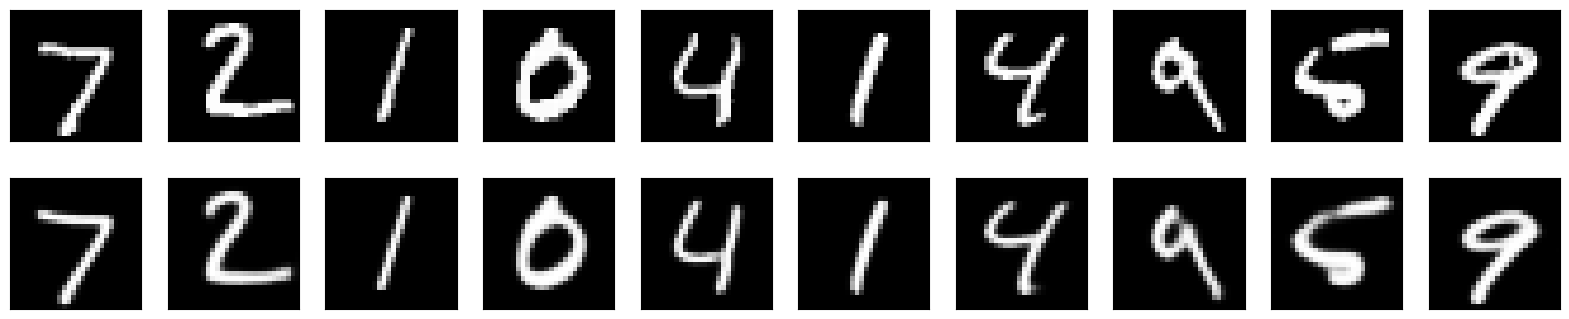

In [142]:
plot()

Finally, we build a digit generator that can sample from the learned distribution

In [143]:
generator = decoder

And we can generate our samples

input digit to generate: 
0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


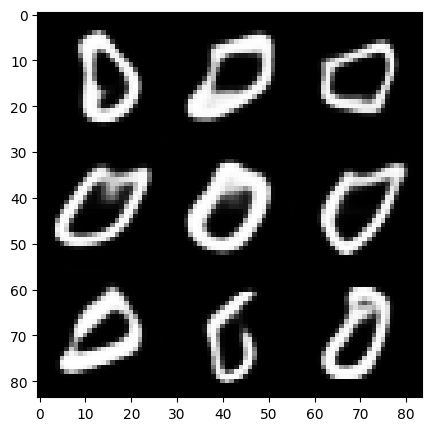

input digit to generate: 
1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


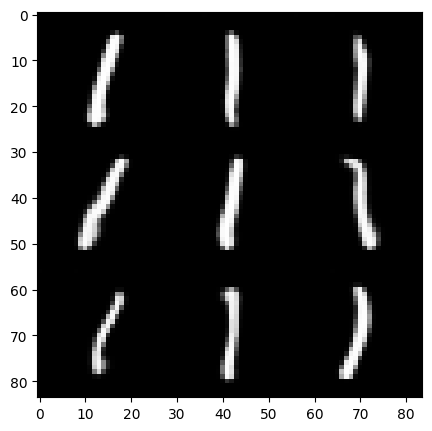

input digit to generate: 
2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


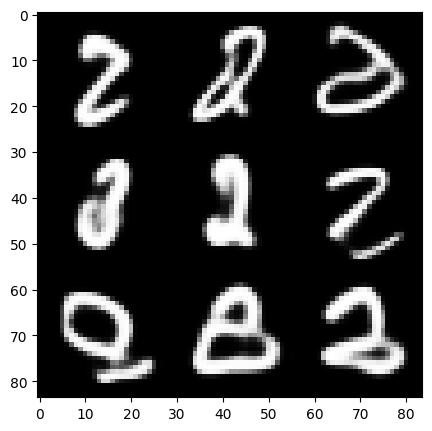

input digit to generate: 
3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


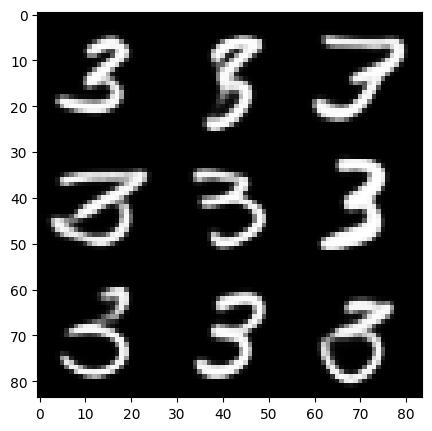

In [ ]:
import time
# display a 2D manifold of the digits
n = 3  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

while True:
  label = input("input digit to generate: \n")
  label = int(label)
  if label < 0 or label > 9:
      print(label)
      break
  label = np.expand_dims(utils.to_categorical(label,10),axis=0)
  for i in range(0,n):
    for j in range (0,n):
        z_sample = np.expand_dims(np.random.normal(size=latent_dim),axis=0)
        x_decoded = generator.predict([z_sample,label])
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit
  plt.figure(figsize=(5, 5))
  plt.imshow(figure, cmap='Greys_r')
  plt.show()
  time.sleep(1)
